# The Lennard-Jones potential for argon
Guido Raos, Politecnico di Milano, April 2024 (guido.raos@polimi.it)

In this notebook we want to familiarize ourselves with the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) (see also [this page](http://www.sklogwiki.org/SklogWiki/index.php/Lennard-Jones_model) on SklogWiki):
\begin{equation}
U_{LJ}(R) = 4\epsilon \left[ \left(\frac{\sigma}{R}\right)^{12} - \left(\frac{\sigma}{R}\right)^{6} \right]
\end{equation}

It is probably the simplest and most widely-used model for non-bonded interactions between electrically neutral atoms, small molecules or molecular fragments (e.g., between rare gases, or two methane molecules). The potential depends on the distance $R$ (it is independent of orientation) and contains two adjustable parameters ($\sigma$ and $\epsilon$).


Some questions:
* It is a good approximation to the interaction energies that can be computed *ab initio*?
* How good are those *ab initio* calculations, anyway?


## Introducing the LJ potential

Let us start by defining two python functions that compute the LJ potential and the force derived from it. In our definitions, $\epsilon$ and $\sigma$ appear as optional arguments of the function call. If they are absent, they are assigned the default value of 1.0.

In [2]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [5]:
def ULJ(r, sigma=1.0, epsilon=1.0):
    """Computes the LJ interaction energy for two atoms, at distance r"""
#    print("Now in ULJ", r, sigma, epsilon)
    sr6 = (sigma / r)**6
    energy = 4 * epsilon * ( sr6**2 - sr6 )
    return energy

def ULJ_der(r, sigma=1.0, epsilon=1.0):
    """Computes the derivative of the LJ energy for two atoms, at distance r"""
    sr = sigma / r
    sr6 = sr**6
    sr7 = sr*sr6
    sr13 = sr6*sr7
    derivative = 24 * (epsilon/sigma) * ( -2.0*sr13 + sr7 )
    return derivative

# Note that these functions can be called with a single distance as argument
# (and return a single value), or with an array of distances
# (and return an array of values).
r = 1.0
rr = np.array([1.,2**(1./6.),2.])
print( ULJ(r) )
print( ULJ(rr) )

0.0
[ 0.         -1.         -0.06152344]


Let us plot the potential and the force, using MatPlotLib:

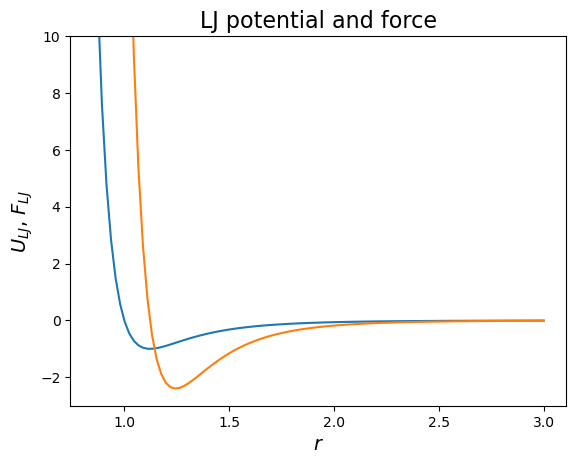

In [6]:
distance = np.linspace(0.85,3,100)
potential = ULJ(distance)
force = -ULJ_der(distance)
plt.plot(distance,potential)
plt.plot(distance,force)
plt.ylim([-3,10])          # avoid plotting very large positive values
plt.xlabel('$r$', size=14) # label for x axis
plt.ylabel('$U_{LJ}$, $F_{LJ}$', size=14) #label for y axis
plt.title('LJ potential and force', size=16); #plot title
plt.show();

**Now your turn:**

Write another version of the ULJ function (call it ULJ2, for example) that takes as an argument the cartesian coordinates of two atoms (instead of the interatomic distance).

## *Ab initio* calculation of the Ar...Ar potential

We may compute the interaction energy between two Ar atoms from first principles, using the ORCA code. Note that the *ab initio* evaluation of weak intermolecular interactions can be challenging, because they require the inclusion of electron correlation effects (London dispersion derives from quantum mechanical *correlations* between fluctuating dipoles). The simplest method including these correlation effects is MP2. So here is an ORCA input to compute an Ar...Ar interaction potential:

```
# MP2 scan of the potential energy curve for Ar...Ar
! MP2 aug-cc-pVTZ TightSCF opt
%geom Scan
      B 0 1 = 2.8, 10.0, 21 # distance that will be scanned
      end
end
* gzmt 0 1
Ar
Ar  1  3.600
*

```
Parts of the input are similar to the energy scan for CO. Note that here we are using a fairly large "correlation consistent" basis set, augmented with diffuse functions (42s17p3d2f contracted to 6s5p3d2f pattern, on each Ar atom). A high quality basis set is necessary for the reliable calculation of weak interactions.

The RHF and MP2 energies at all internuclear distances can be extracted from the bottom of the ORCA output, saved in two ".dat" files, and imported as follows (I have copied them also at the end of this file, for those who do not want to repeat my ORCA calculation):


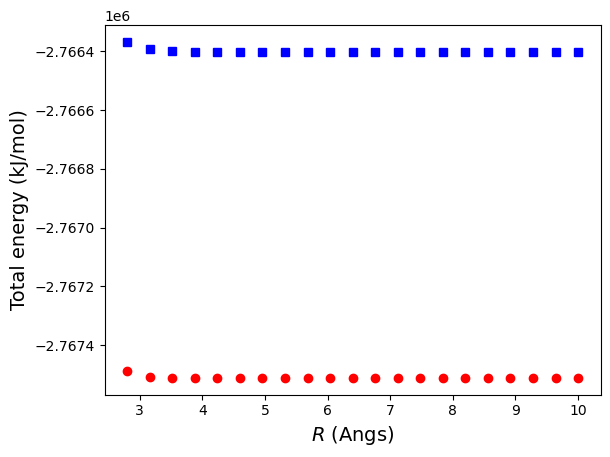

In [7]:
mp2data = np.loadtxt('Ar2_mp2_energies.dat', usecols=[0,1], skiprows=1)
rhfdata = np.loadtxt('Ar2_rhf_energies.dat', usecols=[0,1], skiprows=1)
#print(mp2data)
#print(rhfdata)

Distances = mp2data[:,0]
Emp2 = mp2data[:,1]*2625.6  # Convert from Hartree to kJ/mol
Erhf = rhfdata[:,1]*2625.6  # Convert from Hartree to kJ/mol

plt.plot(Distances, Emp2, 'r o')
plt.plot(Distances, Erhf, 'b s')
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('Total energy (kJ/mol)', size=14)
plt.show()

Clearly, the total energies are not very informative. It is much better to compute the interaction energies, by subtracting twice the energy of an isolated Ar atom (from a separate calculation).


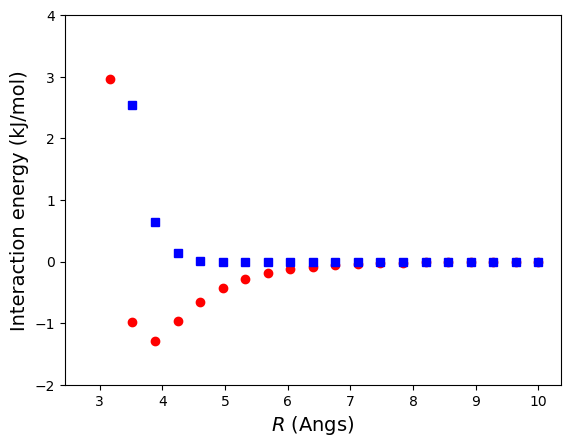

In [8]:
E1rhf = -526.81335217
E1mp2 = -527.024283310

Emp2 = (mp2data[:,1]-2*E1mp2)*2625.6
Erhf = (rhfdata[:,1]-2*E1rhf)*2625.6

plt.plot(Distances, Emp2, 'r o')
plt.plot(Distances, Erhf, 'b s')
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('Interaction energy (kJ/mol)', size=14)
plt.ylim(bottom=-2, top=4)
plt.show()

Note that the Hartree-Fock curve is purely repulsive, as expected. Before we leave it, it is also interesting to plot the correlation energy (difference betweem the RHF and MP2 energies), as a function of the internuclear distance:

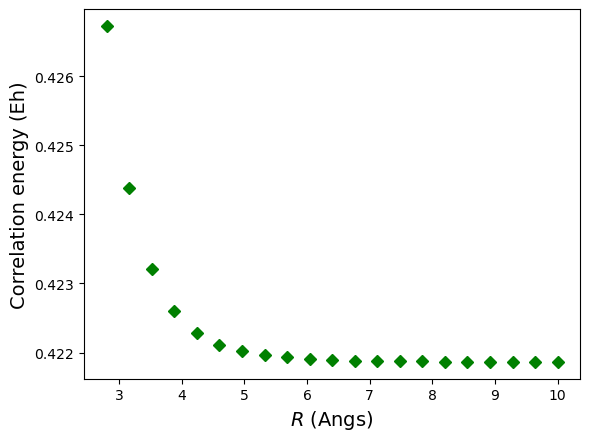

In [9]:
Ecorr = rhfdata[:,1] - mp2data[:,1]

plt.plot(Distances, Ecorr, 'g D')
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('Correlation energy (Eh)', size=14)
plt.show()

Let us now fit the calculated interaction energy with the LJ potential, using the [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) method from [SciPy's optimization](https://docs.scipy.org/doc/scipy/reference/optimize.html) package. We can the plot the fitting LJ potential on top of the MP2 data:

Optimized LJ params: sigma= 3.3628820911481294  epsilon= 0.9024619776078825


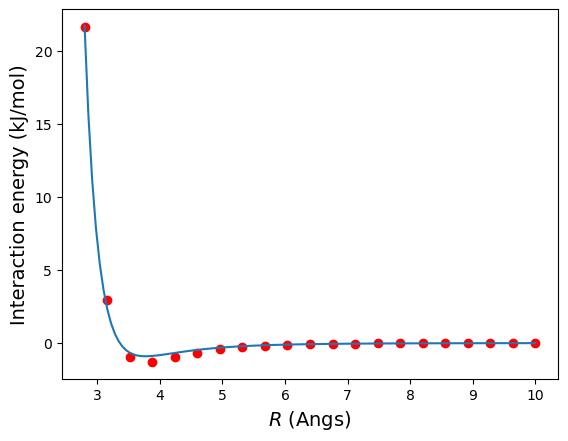

In [10]:
popt, pcov = opt.curve_fit(ULJ, Distances, Emp2, bounds=([3,0],[4,2]))
sigma = popt[0]
epsilon = popt[1]
print("Optimized LJ params: sigma=", sigma, " epsilon=", epsilon)

RLJ = np.linspace(Distances[0],Distances[-1],120)
ELJ = ULJ(RLJ, sigma, epsilon)
plt.plot(Distances, Emp2, 'r o')
plt.plot(RLJ, ELJ)
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('Interaction energy (kJ/mol)', size=14)
#plt.ylim(bottom=-2, top=4)
plt.show()

The fit does not seem "perfect", mostly because the LJ curve tries to fit the first point at very high energy, at the expense of the points close to the minimum (the Buckingham potential would be better in this respect, also because it depends on three parameters). One way to correct this is simply to exclude the first point from the fit.

Optimized LJ params: sigma= 3.345019914650346  epsilon= 1.2951279109153553


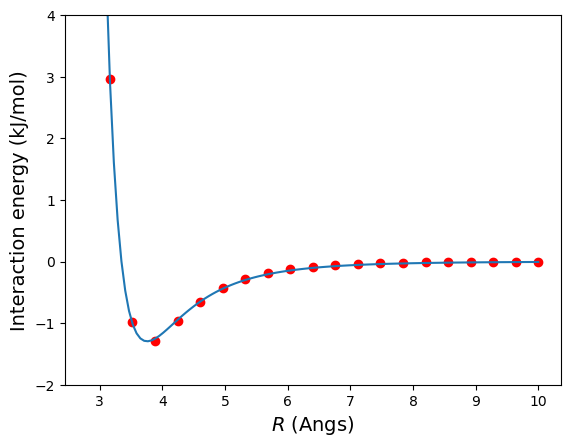

In [11]:
popt, pcov = opt.curve_fit(ULJ, Distances[1:], Emp2[1:], bounds=([3,0],[4,2]))
sigma = popt[0]
epsilon = popt[1]
print("Optimized LJ params: sigma=", sigma, " epsilon=", epsilon)

RLJ = np.linspace(Distances[0],Distances[-1],120)
ELJ = ULJ(RLJ, sigma, epsilon)
plt.plot(Distances, Emp2, 'r o')
plt.plot(RLJ, ELJ)
#plt.ylim(top=5)
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('Interaction energy (kJ/mol)', size=14)
plt.ylim(bottom=-2, top=4)
plt.show()

Another possible strategy to obtain the parameters of the LJ potential would be to [interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) the energies of the three points closest to the minimum with a parabola, and from this obtain the exact location of the minumum and its energy.  Remember that, for the LJ potential:
* $\sigma = R_{min} / 2^{1/6}$
* $\epsilon = -E_{min}$.

Yet another possible strategy would be to go back to ORCA and repeat the MP2 energy scan with tightly spaced points close to the minimum (e.g., between 3.5 and 4.0 Angs).

**Now your turn:**

## Comparison with experiments

To summarize the work so far, we have:
* computed an *ab initio* (MP2/aug-cc-pVTZ) potential energy curve for Ar...Ar
* fitted it with a LJ potential with parameters:  $\sigma=0.3345$ nm, $\epsilon=1.295$ kJ/mol.

**How good is this result?**

The first we can do it to compare with the [LJ parameters for Ar](http://www.sklogwiki.org/SklogWiki/index.php/Argon) used by other authors:
1. Rahman (1964):  $\sigma=0.34$ nm, $\epsilon=0.998$ kJ/mol.	
2. Barker, Fisher and Watts (1971):	$\sigma=0.33605$ nm, $\epsilon=1.181$ kJ/mol. 	
3. Rowley, Nicholson and Parsonage (1975): $\sigma=0.3405$ nm, $\epsilon=0.996$ kJ/mol
4. White (1999): $\sigma=0.3345$ nm, $\epsilon=1.045$.

(the SklogWiki site gives the values of $\epsilon/k_B$, in K). Notice that there are significant differences between these authors. Our calculation seems to agree fairly well with their values of $\sigma$, but compared to *all* of them we are overestimating the energy parameter $\epsilon$.

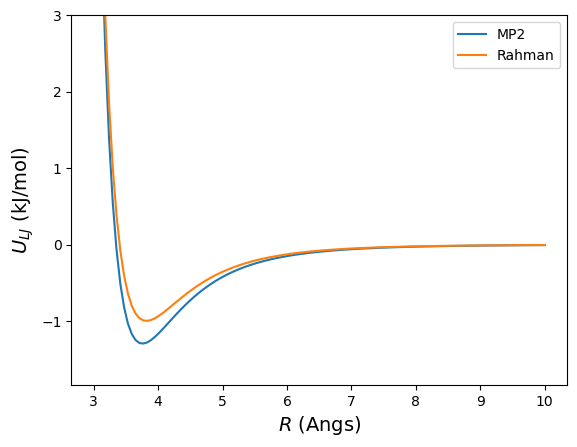

In [12]:
# Comparison of our LJ potential with that Rahman (1964).
sigmaR = 3.4
epsilonR = 0.998
RLJ = np.linspace(3.0,10.0,120)
ELJ = ULJ(RLJ, sigma, epsilon)
ELJR = ULJ(RLJ, sigmaR, epsilonR)
plt.plot(RLJ, ELJ, label="MP2")
plt.plot(RLJ, ELJR, label="Rahman")
plt.ylim(top=3)
plt.xlabel('$R$ (Angs)', size=14)
plt.ylabel('$U_{LJ}$ (kJ/mol)', size=14)
plt.legend()
plt.show()

One possible reason for the disagreement it that our potential was computed from a pair of interacting Ar atoms, whereas the other sets LJ parameters may have been chosen to account in some average way for many-body corrections to the pairwise potential, that occur especially in condensed phased (liquids and solids). Perhaps our potential is better at reproducing the gas-phase properties of Ar, whereas the other potentials are better for condensed-phase properties (or across the whole Ar phase diagram, for different temperatures, pressures and densities)?

One *experimental* gas-phase property of Ar that can be used for a comparison is its [second virial coefficient](http://www.sklogwiki.org/SklogWiki/index.php/Virial_equation_of_state) $B_2$. This is the first term in a series that describes deviations of the [equation of state](https://en.wikipedia.org/wiki/Equation_of_state) of a real gas, from that expected for an ideas gas:
\begin{equation}
Z = \frac{pV_m}{RT} = 1 + \frac{B_2}{V_m} + \frac{B_3}{V_m^2} + \frac{B_4}{V_m^3} + \cdots
\end{equation}
where $R$ is the gas constant,, $p$ is the pressure, $T$ is the absolute temperature, and $V_m$ is the molar volume ($=V/n$). Note that $B_2$ has the dimension of a molar volume (i.e., it is measured in L/mol). Note also that the virial coefficients $B_k$ depend on temperature, in general. 

The connection between the virial coefficients of a gas and the interaction potentials between its atoms/molecules can be derived by statistical mechanics (see also [here](http://www.sklogwiki.org/SklogWiki/index.php/Second_virial_coefficient)). The second virial coefficient can be obtained by a one-dimensional integral:
\begin{equation}
B_2(T) = \frac{1}{2} \int_0^\infty \left( 1 - \exp\left(-\frac{U(R)}{RT}\right) \right) 4 \pi R^2 dR 
\end{equation}
where $U(R)$ is the pairwise interaction potential (which in the general case of molecules depends also on their relative orientation, in addition to their distance). Note that within the exponential I have used the gas constant $R$ instead of $k_B$ (why?). The higher order coefficients are more complicated as they involve multi-dimensional integrals.


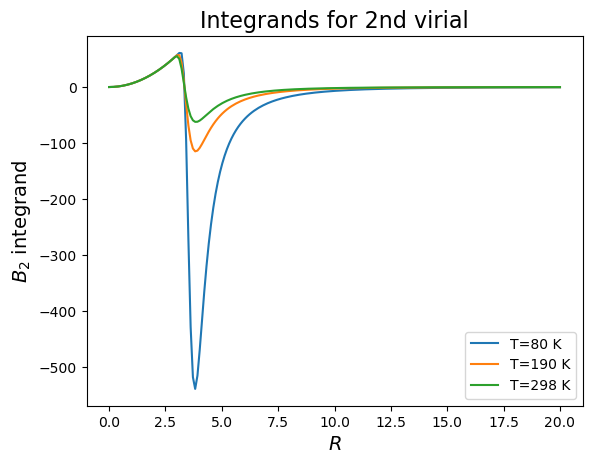

In [13]:
def B2iLJ(r, sigma, epsilon, T, units="LJ"):
    """Computes the integrand of the B2 coefficient for the LJ potential"""
    if units == "LJ":                   # Reduced LJ units
        sigma = 1.
        epsilon = 1.
        Rgas = 1.
    elif units == "SI":
        Rgas = 8.3144626*10**(-3)   # in kJ/(mol K)
    U = ULJ(r, sigma, epsilon)
    integrand = ( 1 - np.exp(-U /(Rgas*T)) ) * 2*np.pi*r**2
    return integrand

sigma= 3.345
epsilon= 1.295
R = np.linspace(0.00001,20,200)
T = 80
int80 = B2iLJ(R,sigma,epsilon, T, units="SI")
T = 190
int190 = B2iLJ(R,sigma,epsilon, T, units="SI")
T = 298
int298 = B2iLJ(R,sigma,epsilon, T, units="SI")

plt.plot(R, int80, label="T=80 K")
plt.plot(R, int190, label="T=190 K")
plt.plot(R, int298, label="T=298 K")
#plt.ylim([-3,10])          # avoid plotting very large positive values
plt.xlabel('$R$', size=14) # label for x axis
plt.ylabel('$B_2$ integrand', size=14) #label for y axis
plt.title('Integrands for 2nd virial', size=16); #plot title
plt.legend()
plt.show();

This paper contains the resuts of experimental measurements of $B_2$:
* R. D. Weir, I. Wynn Jones, J. S. Rowlinson and G. Saville, "Equation of state of gases at low temperatures. Part 1.—Second virial coefficient of argon and krypton", *Trans. Faraday Soc.*, 1967, **63**, 1320-1329 (https://doi.org/10.1039/TF9676301320).

Below are the argon data (temperature and B2 values) extracted from Table 1 of the paper:

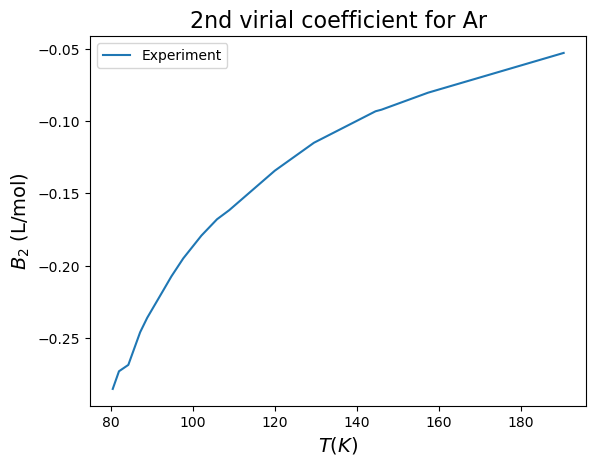

In [14]:
T = np.array( [80.43, 81.95, 84.23, 87.12, 88.85, 92.78, 94.75, 97.65, \
    102.08, 105.89, 108.87, 120.00, 129.56, 144.60, 146.05, 157.41, 190.52] )
B2 = np.array( [-0.2851, -0.2729, -0.2685, -0.2459, -0.2359, -0.2169, -0.20730, \
      -0.19485, -0.17910, -0.16782, -0.16154, -0.13425, -0.11493, -0.09318, \
      -0.09208, -0.08034, -0.05285] )
#print(T.shape, B2.shape)

plt.plot(T, B2, label="Experiment")
plt.xlabel('$T (K)$', size=14) # label for x axis
plt.ylabel('$B_2$ (L/mol)', size=14) #label for y axis
plt.title('2nd virial coefficient for Ar', size=16); #plot title
plt.legend()
plt.show();

**Now your turn:**

* Use SciPy's [Integration](https://docs.scipy.org/doc/scipy/tutorial/integrate.html) to compute the second virial coefficient from our LJ potential (or the potential from the other authors) and compare it to the experiment.

Another relatively simple route to test our potential for Argon is to compare the experimental data for its triple point and critical point (temperature, pressure and density) to those of the Lennard-Jones fluid (derived by theory and simulation):
* http://www.sklogwiki.org/SklogWiki/index.php/Argon
* http://www.sklogwiki.org/SklogWiki/index.php/Lennard-Jones_model


## Suggestions for further work

The following could evolve into a end-of-course project, to be discussed at the exam:
* Test the effect of changing the basis set and electron correlation method (e.g. CCSD). Does this improve the comparison to experiment?
* Compute the interaction potentials also for other rare gases. Test the validity of different "mixing rules" for the interaction between unlike atoms.
* Compute *ab initio* the interaction between three or more Ar atoms. Are the energies additive? In other words, is the assumption of strictly pairwise interactions valid?
* Read about the "basis set superposition error" and why it can affect the evaluation of intermolecular interactions? What are the strategies to minimize or avoid it?
* ORCA implements a "Hartree-Fock plus London Dispersion (HFLD) method for the study of Noncovalent Interactions". Read about it, try to understand the underlying theory, and test it with some applications.


## Appendix: RHF and MP2 energies for Ar...Ar

The following lines come from the bottom of my ORCA output file (switch to "edit" mode to see in nice coloumns).

The Calculated Surface using the SCF energy
   2.80000000 -1053.61362046
   3.16000000 -1053.62306068
   3.52000000 -1053.62573718
   3.88000000 -1053.62645858
   4.24000000 -1053.62664893
   4.60000000 -1053.62669960
   4.96000000 -1053.62671030
   5.32000000 -1053.62671015
   5.68000000 -1053.62670839
   6.04000000 -1053.62670689
   6.40000000 -1053.62670577
   6.76000000 -1053.62670505
   7.12000000 -1053.62670466
   7.48000000 -1053.62670448
   7.84000000 -1053.62670439
   8.20000000 -1053.62670436
   8.56000000 -1053.62670435
   8.92000000 -1053.62670434
   9.28000000 -1053.62670434
   9.64000000 -1053.62670433
  10.00000000 -1053.62670433
  
  The Calculated Surface using the MP2 energy
   2.80000000 -1054.04034847
   3.16000000 -1054.04743840
   3.52000000 -1054.04893992
   3.88000000 -1054.04905771
   4.24000000 -1054.04893309
   4.60000000 -1054.04881475
   4.96000000 -1054.04873069
   5.32000000 -1054.04867468
   5.68000000 -1054.04863845
   6.04000000 -1054.04861492
   6.40000000 -1054.04859939
   6.76000000 -1054.04858910
   7.12000000 -1054.04858228
   7.48000000 -1054.04857775
   7.84000000 -1054.04857471
   8.20000000 -1054.04857262
   8.56000000 -1054.04857116
   8.92000000 -1054.04857012
   9.28000000 -1054.04856936
   9.64000000 -1054.04856879
  10.00000000 -1054.04856836